In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import toml
import torch
import joblib
from statsmodels.stats.multitest import multipletests
from torch.utils.data import DataLoader
from m6anet.utils.builder import random_fn
from m6anet.utils.data_utils import NanopolishDS, inference_collate
from m6anet.model.model import MILModel
from tqdm.notebook import tqdm
from pyensembl import Genome
from multiprocessing import Pool
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
selection_criteria = "pr_auc"
ROOT_PATH = "/home/christopher/m6anet/m6anet/"
NORM_PATH = os.path.join(ROOT_PATH, "model/norm_factors/norm_dict.joblib")
DEFAULT_MODEL_CONFIG = "../m6anet/model/configs/model_configs/1_neighbor/prod_pooling.toml"
DEFAULT_MODEL_WEIGHTS = "../m6anet/model/model_states/prod_pooling_pr_auc.pt"
MIN_READS = 20

In [3]:
def create_dl(input_dir, batch_size, num_workers):
    ds = NanopolishDS(input_dir, MIN_READS, NORM_PATH, mode='Inference')
    dl = DataLoader(ds, num_workers=num_workers, collate_fn=inference_collate, 
                    batch_size=batch_size, worker_init_fn=random_fn, shuffle=False)
    return dl

def get_read_level_probability(model, dl, device, n_iterations=1):
    """
    Run inference on unlabelled dataset
    """
    model.eval()
    all_y_pred = []
    with torch.no_grad():
        for n in range(n_iterations):
            y_pred_tmp = []
            for batch in dl:
                X = {key: val.to(device) for key, val in batch.items()}
                y_pred = model.get_read_probability(X)
                y_pred = 1 - torch.prod(1 - y_pred, axis=1)
                y_pred = y_pred.detach().cpu().numpy()
                if (len(y_pred.shape) == 1) or (y_pred.shape[1] == 1):
                    y_pred_tmp.extend(y_pred.flatten())
                else:
                    y_pred_tmp.extend(y_pred[:, 1])

            all_y_pred.append(y_pred_tmp)
    return np.mean(all_y_pred, axis=0)


In [4]:
device = 'cuda:2'
model_config = toml.load(DEFAULT_MODEL_CONFIG)
model_state_dict = torch.load(DEFAULT_MODEL_WEIGHTS, map_location=torch.device(device))

model = MILModel(model_config).to(device)
model.load_state_dict(model_state_dict)
model.eval()
batch_size = 512
num_workers = 25
hek293_dirs = ["/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-25_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-50_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-75_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTL3-KO_directRNA_Rep2_Run1"]
hek293_dls = {input_dir.split("/")[-1]: create_dl(input_dir, batch_size, num_workers) for 
              input_dir in hek293_dirs}


In [5]:
hek293_dls

{'GohGIS_Hek293T_directRNA_Rep2': <torch.utils.data.dataloader.DataLoader at 0x7f080aa65730>,
 'GohGIS_Hek293T-METTLE3-KO-25_directRNA_Rep1-Run1': <torch.utils.data.dataloader.DataLoader at 0x7f080a042df0>,
 'GohGIS_Hek293T-METTLE3-KO-50_directRNA_Rep1-Run1': <torch.utils.data.dataloader.DataLoader at 0x7f07eefe3fd0>,
 'GohGIS_Hek293T-METTLE3-KO-75_directRNA_Rep1-Run1': <torch.utils.data.dataloader.DataLoader at 0x7f088830cca0>,
 'GohGIS_Hek293T-METTL3-KO_directRNA_Rep2_Run1': <torch.utils.data.dataloader.DataLoader at 0x7f080a5c2d00>}

In [6]:
def get_read_site_probability(model, dl, device, n_iterations=5):
    """
    Run inference on unlabelled dataset
    """
    model.eval()
    all_y_pred_read = []
    all_y_pred_site = []
    all_read_rep = []
    with torch.no_grad():
        for i in range(n_iterations):
            all_y_pred_read_tmp = []
            all_y_pred_site_tmp = []
            all_read_rep_tmp = []
            for batch in dl:
                X = {key: val.to(device) for key, val in batch.items()}
                y_pred_read, y_pred_site, read_rep = model.get_read_site_probability(X)
                all_y_pred_read_tmp.append(y_pred_read.detach().cpu().numpy().reshape(-1, 20, 1))
                all_y_pred_site_tmp.append(y_pred_site.detach().cpu().numpy().reshape(-1, 1))
                all_read_rep_tmp.append(read_rep.detach().cpu().numpy().reshape(-1, 20, 32))
            
            all_y_pred_read.append(np.concatenate(all_y_pred_read_tmp))
            all_y_pred_site.append(np.concatenate(all_y_pred_site_tmp))
            all_read_rep.append(np.concatenate(all_read_rep_tmp))
    return np.concatenate(all_y_pred_read, axis=1), np.concatenate(all_y_pred_site, axis=1), \
        np.concatenate(all_read_rep, axis=1)

def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["gene_id"] = gt_map["g_id"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)

gt_dir = "/data03/christopher/gt_mapping_final/"
# high_confidence_positions = add_genomic_position(high_confidence_positions)


In [7]:
wt_dl, ko_dl = hek293_dls['GohGIS_Hek293T_directRNA_Rep2'], hek293_dls['GohGIS_Hek293T-METTL3-KO_directRNA_Rep2_Run1']
wt_sites, ko_sites = wt_dl.dataset.data_info, ko_dl.dataset.data_info
wt_sites["wt_index"] = np.arange(len(wt_sites))
ko_sites["ko_index"] = np.arange(len(ko_sites))

shared_sites = wt_sites.merge(ko_sites, on=["transcript_id", "transcript_position"])
y_pred_read_wt, y_pred_site_wt, read_rep_wt = get_read_site_probability(model, wt_dl, device)
y_pred_read_ko, y_pred_site_ko, read_rep_ko = get_read_site_probability(model, ko_dl, device)
shared_sites["probability_modified_wt"] = shared_sites["wt_index"].apply(lambda x: np.mean(y_pred_site_wt[x]))
shared_sites["probability_modified_ko"] = shared_sites["ko_index"].apply(lambda x: np.mean(y_pred_site_ko[x]))
shared_sites = add_genomic_position(shared_sites, 25)

  0%|          | 0/4406 [00:00<?, ?it/s]

In [8]:
all_kmers, counts = np.unique(shared_sites["kmer"], return_counts=True)
all_kmers[np.argsort(-counts)]

array(['GGACC', 'GGACA', 'AAACA', 'TGACC', 'TGACA', 'GAACA', 'AGACC',
       'AAACT', 'AGACA', 'GGACT', 'TGACT', 'GAACT', 'GAACC', 'AAACC',
       'AGACT', 'TAACA', 'TAACT', 'TAACC'], dtype=object)

,PC1,PC2,read_probability,site_probability,data_type,site
0,-5.901715,0.544980,4.270363e-01,0.999991,WT,ENST00000331925_607
1,-5.274919,2.482571,4.123752e-01,0.999991,WT,ENST00000331925_607
2,-5.264108,2.177034,5.328743e-01,0.999991,WT,ENST00000331925_607
3,-5.422348,2.224755,4.364520e-01,0.999991,WT,ENST00000331925_607
4,-4.494907,1.014319,4.446557e-01,0.999991,WT,ENST00000331925_607
...,...,...,...,...,...,...
195,4.318550,-2.856837,2.333132e-05,0.000161,KO,ENST00000300291_100
196,11.834605,-4.568213,3.323572e-08,0.000161,KO,ENST00000300291_100
197,5.091653,-2.680590,9.762922e-06,0.000161,KO,ENST00000300291_100
198,13.171178,-2.375555,1.231107e-08,0.000161,KO,ENST00000300291_100


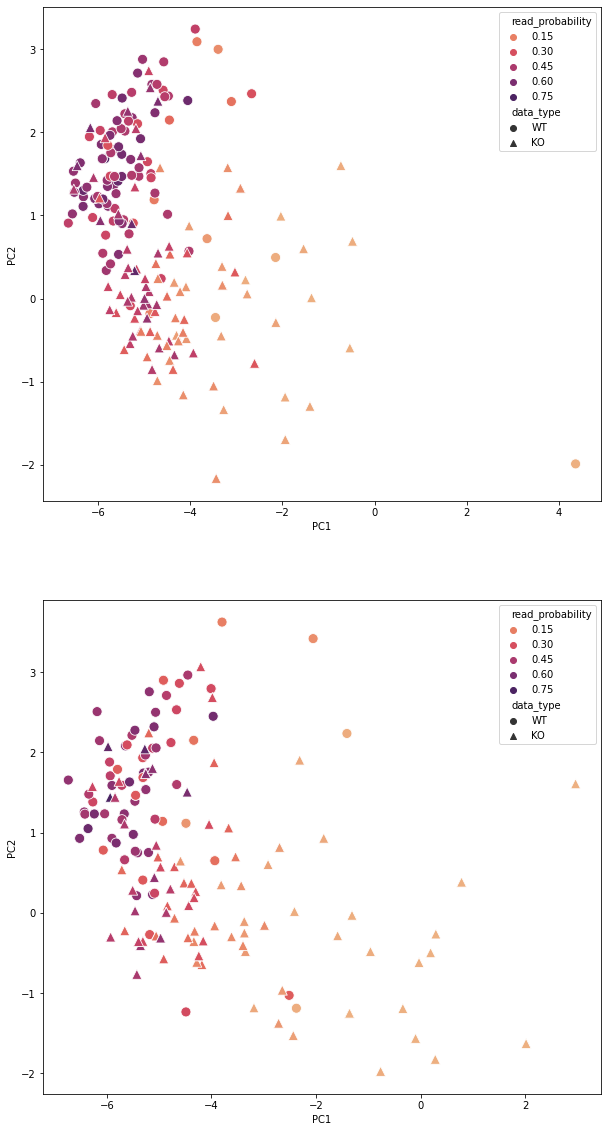

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20))
kmers = all_kmers[np.argsort(-counts)][:8]
high_confidence_positions = shared_sites
sort_idx = np.argsort(-(high_confidence_positions.probability_modified_wt))

wt_indices = high_confidence_positions.reset_index(drop=True).iloc[sort_idx]["wt_index"]
ko_indices = high_confidence_positions.reset_index(drop=True).iloc[sort_idx]["ko_index"]
wt_site_probs =  high_confidence_positions.reset_index(drop=True).iloc[sort_idx]["probability_modified_wt"]
ko_site_probs =  high_confidence_positions.reset_index(drop=True).iloc[sort_idx]["probability_modified_ko"]

coords = high_confidence_positions.reset_index(drop=True).iloc[sort_idx].apply(lambda x: x["transcript_id"] + "_" + \
                                                                              str(x["transcript_position"]), axis=1)

wt_reps = np.concatenate([read_rep_wt[idx] for idx in wt_indices])
ko_reps = np.concatenate([read_rep_ko[idx] for idx in ko_indices])
combined_reps = np.concatenate([wt_reps, ko_reps])
scaler = StandardScaler().fit(combined_reps)
pca = PCA(n_components=0.99, svd_solver='full').fit(scaler.transform(combined_reps))
ratio = pca.explained_variance_ratio_
to_plot_df = []
i = 0
for wt_index, ko_index, coord, wt_site_prob, ko_site_prob in zip(wt_indices, ko_indices, coords, wt_site_probs, ko_site_probs):
    wt_rep = read_rep_wt[wt_index]
    ko_rep = read_rep_ko[ko_index]
    
    max_prob = max(np.max(y_pred_read_wt[wt_index].flatten()), np.max(y_pred_read_ko[ko_index].flatten()))
    min_prob = min(np.min(y_pred_read_wt[wt_index].flatten()), np.min(y_pred_read_ko[ko_index].flatten()))
    
#     wt_read_prob = (y_pred_read_wt[wt_index].flatten() - min_prob) / (max_prob - min_prob)
#     ko_read_prob = (y_pred_read_ko[ko_index].flatten() - min_prob) / (max_prob - min_prob)
    
    
    wt_read_prob = y_pred_read_wt[wt_index].flatten()
    ko_read_prob = y_pred_read_ko[ko_index].flatten()
    
    wt_labels = np.repeat("WT", len(wt_read_prob))
    ko_labels = np.repeat("KO", len(ko_read_prob))
    
    combined_rep = np.concatenate([wt_rep, ko_rep])
    combined_rep = scaler.transform(combined_rep)
    combined_rep = pca.transform(combined_rep)

    to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                            'read_probability': np.concatenate([wt_read_prob, ko_read_prob]),
                            'site_probability': np.concatenate([np.repeat(wt_site_prob, len(wt_read_prob)),
                                                                np.repeat(ko_site_prob, len(ko_read_prob))]),
                            'data_type': np.concatenate([wt_labels, ko_labels])})
    
    to_plot["site"] = coord
    to_plot_df.append(to_plot)
    if i < 2:
        sns.scatterplot(x='PC1', y='PC2', hue="read_probability", palette='flare',
                        style='data_type', data=to_plot, markers={'WT': 'o', 'KO':'^'}, s=100,
                        ax=axes[i])
    i += 1
        

to_plot_df = pd.concat(to_plot_df)
to_plot_df

In [10]:
to_plot_df["transcript_id"] = to_plot_df["site"].apply(lambda x: x.split("_")[0])
to_plot_df["transcript_position"] = to_plot_df["site"].apply(lambda x: int(x.split("_")[1]))
to_plot_df = add_genomic_position(to_plot_df, 25)

  0%|          | 0/4406 [00:00<?, ?it/s]

In [11]:
np.random.seed(0)

def sample_sites(df):
    index = np.random.choice(100, 20, replace=False)
    return df.reset_index(drop=True).iloc[index].reset_index(drop=True)

grouped_plot_df = (df for _, df in to_plot_df.groupby(["site", "data_type"]))

with Pool(25) as p:
    sampled_plot_df = [x for x in tqdm(p.imap_unordered(sample_sites, grouped_plot_df))]
sampled_plot_df = pd.concat(sampled_plot_df)


0it [00:00, ?it/s]

In [12]:
palette ={"WT": "blue", "KO": "grey"}


In [13]:
import pickle

In [14]:
# wt_sampled_plot = sampled_plot_df[sampled_plot_df["data_type"] == 'WT'].reset_index(drop=True)
# ko_sampled_plot = sampled_plot_df[sampled_plot_df["data_type"] == 'KO'].reset_index(drop=True)

# wt_lim = (np.quantile(wt_sampled_plot["PC1"], 0.05), np.quantile(wt_sampled_plot["PC1"], 0.95),
#           np.quantile(wt_sampled_plot["PC2"], 0.05), np.quantile(wt_sampled_plot["PC2"], 0.95))

# ko_lim = (np.quantile(ko_sampled_plot["PC1"], 0.05), np.quantile(ko_sampled_plot["PC1"], 0.95),
#           np.quantile(ko_sampled_plot["PC2"], 0.05), np.quantile(ko_sampled_plot["PC2"], 0.95))

# wt_sampled_plot = wt_sampled_plot[wt_sampled_plot["PC1"].between(wt_lim[0], wt_lim[1])].reset_index(drop=True)
# wt_sampled_plot = wt_sampled_plot[wt_sampled_plot["PC2"].between(wt_lim[2], wt_lim[3])].reset_index(drop=True)

# ko_sampled_plot = ko_sampled_plot[ko_sampled_plot["PC1"].between(ko_lim[0], ko_lim[1])].reset_index(drop=True)
# ko_sampled_plot = ko_sampled_plot[ko_sampled_plot["PC2"].between(ko_lim[2], ko_lim[3])].reset_index(drop=True)

# sampled_plot_df = pd.concat([wt_sampled_plot, ko_sampled_plot])

(-5.0, 5.0)

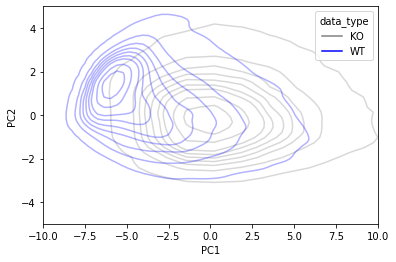

In [14]:
mask1 = sampled_plot_df["site_probability"] <= 0.2
mask2 = sampled_plot_df["data_type"] == 'KO'
mask3 = sampled_plot_df["site_probability"] >= 0.8
mask4 = sampled_plot_df["data_type"] == 'WT'
kmer_mask = sampled_plot_df["kmer"].isin(['GGACT', 'GAACT', 'GGACA', 'AGACT'])
mask = ((mask1 & mask2) | (mask3 & mask4)) & kmer_mask

g = sns.kdeplot(x='PC1', y='PC2', hue='data_type', data=sampled_plot_df[mask].reset_index(drop=True),
                palette=palette, alpha=0.3)

g.axes.set_xlim(-10, 10)
g.axes.set_ylim(-5, 5)


In [15]:
with open('kde_plot_4_kmers.pkl', 'wb') as fid:
    pickle.dump(g, fid)

In [ ]:
mask1 = sampled_plot_df["site_probability"] <= 0.2
mask2 = sampled_plot_df["data_type"] == 'KO'
mask3 = sampled_plot_df["site_probability"] >= 0.8
mask4 = sampled_plot_df["data_type"] == 'WT'

all_kmers = sampled_plot_df["kmer"].unique()

kmer_dir = "./kmer_density"

if not os.path.exists(kmer_dir):
    os.mkdir(kmer_dir)
    
for kmer in tqdm(all_kmers):
    kmer_mask = sampled_plot_df["kmer"].isin([kmer]).values
    mask = ((mask1 & mask2) | (mask3 & mask4)) & kmer_mask
    plot_df = sampled_plot_df[mask]
    fig, ax = plt.subplots()
    sns.kdeplot(x='PC1', y='PC2', hue='data_type', data=plot_df.reset_index(drop=True),
                    palette=palette, alpha=0.3, ax=ax
    )
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5, 5)

    fig.savefig(os.path.join(kmer_dir, "{}_density.svg".format(kmer)))
#     wt_sites = plot_df[plot_df["data_type"] == 'WT']
#     ko_sites = plot_df[plot_df["data_type"] == 'KO']
    
#     if len(wt_sites) == 0:
#         top_site = ko_sites.sort_values("site_probability")["site"].values[0]
#     elif len(ko_sites) == 0:
#         top_site = wt_sites.sort_values("site_probability", ascending=False)["site"].values[0]
#     else:
#         random_sites = np.array([wt_sites.sort_values("site_probability", ascending=False)["site"].values[0],
#                                  ko_sites.sort_values("site_probability")["site"].values[0]])
#     sub_to_plot = sampled_plot_df[mask][sampled_plot_df[mask]["site"].isin(random_sites)]
#     sns.scatterplot(x='PC1', y='PC2', data=points.reset_index(drop=True),
#                     hue="read_probability",
#                     palette='flare', s=100, vmin=0, vmax=1,
#                     alpha=1,
#                     ax=ax)
#     fig.savefig("{}_density_scatter.svg".format(kmer))


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
proba_mask = ((shared_sites["probability_modified_wt"] >= 0.8) & (shared_sites["probability_modified_ko"] <= 0.2)).values
kmer_mask = shared_sites["kmer"].isin(kmers).values

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.plot(np.arange(len(shared_sites[proba_mask & kmer_mask])),
                shared_sites[proba_mask & kmer_mask]["probability_modified_wt"].values, label="WT"
               , linestyle='--', marker='o', color='b')
plt.plot(np.arange(len(shared_sites[proba_mask & kmer_mask])),
             shared_sites[proba_mask & kmer_mask]["probability_modified_ko"].values, label="KO",
          linestyle='--', marker='o', color='orange')
plt.legend()
fig.savefig("./quantification_plots_lax/scatterplots_ko_wt_sites.svg")

In [24]:
shared_sites["probability_difference"] = shared_sites["probability_modified_wt"] \
    - shared_sites["probability_modified_ko"]
shared_sites["site"] = shared_sites.apply(lambda x: "{}_{}".format(x["transcript_id"], x["transcript_position"]),
                                          axis=1)
shared_sites = shared_sites.sort_values("probability_modified_wt", ascending=False)
proba_mask = ((shared_sites["probability_modified_wt"] >= 0.8) & (shared_sites["probability_modified_ko"] <= 0.2)).values
kmer_mask = shared_sites["kmer"].isin(kmers).values
sorted_sites = shared_sites["site"][proba_mask & kmer_mask].values
figures = []
if not os.path.exists("quantification_plots_lax"):
    os.mkdir("quantification_plots_lax")
cmap = sns.color_palette("flare", as_cmap=True)
for i in range(4):
    site = sorted_sites[i]
    points = to_plot_df[to_plot_df["site"] == site]
    wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
    ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
    combined_rep = np.concatenate([wt_rep, ko_rep])

    wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
    ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

    wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

    wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
    ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

    read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
    site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
    data_type = np.concatenate([wt_labels, ko_labels])

    to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                            'read_probability': read_probs,
                            'site_probability': site_probs,
                            'data_type': data_type})
    
    wt_points = to_plot[to_plot["data_type"] == 'WT']
    ko_points = to_plot[to_plot["data_type"] == 'KO']
    
#     for point, marker, data_type in zip([wt_points, ko_points], ['o', '^'], ['WT', 'KO']):
        
#         with open('./kde_plot_4_kmers.pkl','rb') as fid:
#             f = pickle.load(fid)
#             f.axes.scatter(points["PC1"], points["PC2"], c=[cmap(x) for x in points["read_probability"]],
#                            marker=marker, vmin=0, vmax=1)
#             f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
#             f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))
#             figures.append(f)
#             f.figure.savefig("quantification_plots_lax/quantification_plot_{}_{}.svg".format(data_type, i + 1))
    with open('./kde_plot_4_kmers.pkl','rb') as fid:
        f = pickle.load(fid) 
        a = f.axes.scatter(wt_points["PC1"], wt_points["PC2"], c=[cmap(x) for x in wt_points["read_probability"]],
                   marker='o', vmin=0, vmax=1, label='WT', alpha=1)
        b = f.axes.scatter(ko_points["PC1"], ko_points["PC2"], c=[cmap(x) for x in ko_points["read_probability"]],
                   marker='^', vmin=0, vmax=1, label='KO', alpha=1)
        f.axes.legend(handles=[a, b])
        f.figure.savefig("quantification_plots_lax/quantification_plot_all_{}.svg".format(i + 1))

        figures.append(f)

#     sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
#                        hue="read_probability",
#                     palette='flare',
#                     data=to_plot, s=100, vmin=0, vmax=1,
#                     alpha=1,
#                     ax=f.axes)
    f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
    f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))

#     f.figure.savefig("quantification_plots_lax/quantification_plot_{}_sort_by_diff.svg".format(i + 1))


In [153]:
%%bash

rm -rf quantification_plots_lax/

In [22]:
fig.savefig("quantification_plots_lax/colorbar.svg")

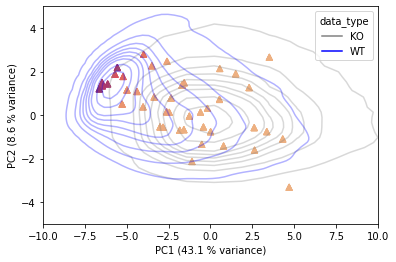

In [19]:
figures[1].figure

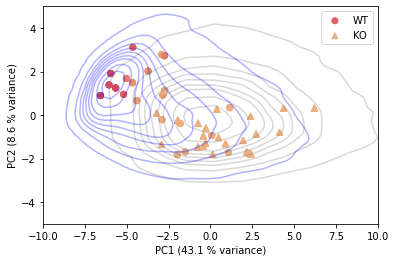

In [20]:
figures[-1].figure


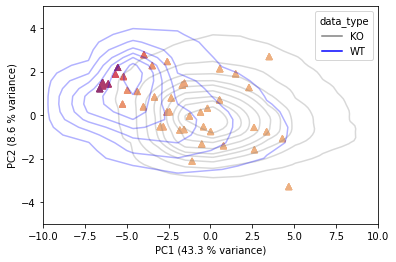

In [25]:
figures[1].figure

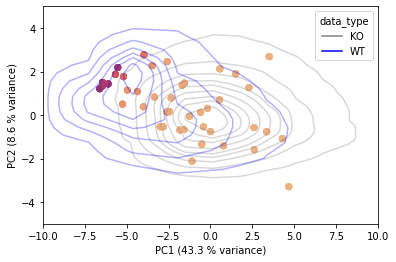

In [26]:
figures[0].figure

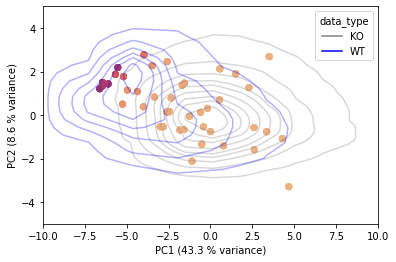

In [27]:
figures[0].figure

In [34]:
shared_sites["probability_difference"] = shared_sites["probability_modified_wt"] \
    - shared_sites["probability_modified_ko"]
shared_sites["site"] = shared_sites.apply(lambda x: "{}_{}".format(x["transcript_id"], x["transcript_position"]),
                                          axis=1)
shared_sites = shared_sites.sort_values("probability_modified_wt", ascending=False)
proba_mask = ((shared_sites["probability_modified_wt"] >= 0.8) & (shared_sites["probability_modified_ko"] <= 0.2)).values
kmer_mask = shared_sites["kmer"].isin(kmers).values
sorted_sites = shared_sites["site"][proba_mask & kmer_mask].values

for i in range(4):
    site = sorted_sites[i]
    points = to_plot_df[to_plot_df["site"] == site]
    wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
    ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
    combined_rep = np.concatenate([wt_rep, ko_rep])

    wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
    ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

    wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

    wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
    ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

    read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
    site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
    data_type = np.concatenate([wt_labels, ko_labels])

    to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                            'read_probability': read_probs,
                            'site_probability': site_probs,
                            'data_type': data_type})
    for data_type in ['WT', 'KO']:
        sub_to_plot = to_plot[to_plot["data_type"] == data_type]
        with open('./kde_plot_4_kmers.pkl','rb') as fid:
            f = pickle.load(fid)
        sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
                        hue="read_probability",
                        palette='flare',
                        data=sub_to_plot, s=100, vmin=0, vmax=1,
                        alpha=1,
                        ax=f.axes)
        f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
        f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))
        f.figure.savefig("quantification_plots_lax/quantification_plot_{}_{}_sort_by_p.svg".format(data_type, i + 1))
    with open('./kde_plot_4_kmers.pkl','rb') as fid:
        f = pickle.load(fid) 
    sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
                       hue="read_probability",
                    palette='flare',
                    data=to_plot, s=100, vmin=0, vmax=1,
                    alpha=1,
                    ax=f.axes)
    f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
    f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))

    f.figure.savefig("quantification_plots_lax/quantification_plot_{}.svg_sort_by_p.svg".format(i + 1))


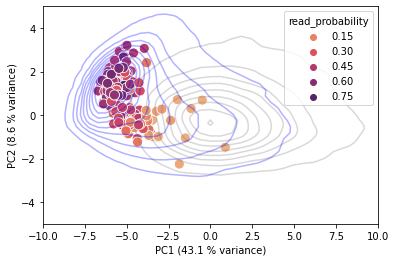

In [203]:
i = 0

# sorted_sites = sampled_plot_df.groupby(["site"])["site_probability"].mean().sort_values(ascending=False).index

site = sorted_sites[i]
# sort_idx = np.arange()
 
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)

points = to_plot_df[to_plot_df["site"] == site]
wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
combined_rep = np.concatenate([wt_rep, ko_rep])

wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
data_type = np.concatenate([wt_labels, ko_labels])

to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                        'read_probability': read_probs,
                        'site_probability': site_probs,
                        'data_type': data_type})

sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
                   hue="read_probability",
                palette='flare',
                data=to_plot, s=100, vmin=0, vmax=1,
                alpha=1,
                ax=f.axes)
f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))

f.figure.savefig("quantification_plot_1.svg")
f.figure

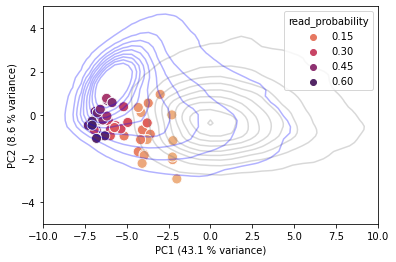

In [202]:
i = 1

sorted_sites = sampled_plot_df.groupby(["site"])["site_probability"].mean().sort_values(ascending=False).index

site = sorted_sites[i]
# sort_idx = np.arange()
 
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)

points = to_plot_df[to_plot_df["site"] == site]
wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
combined_rep = np.concatenate([wt_rep, ko_rep])

wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
data_type = np.concatenate([wt_labels, ko_labels])

to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                        'read_probability': read_probs,
                        'site_probability': site_probs,
                        'data_type': data_type})

sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
                   hue="read_probability", 
                palette='flare',
                data=to_plot, s=100,vmin=0, vmax=1,
                alpha=1,
                ax=f.axes)
f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))

f.figure.savefig("quantification_plot_2.svg")
f.figure

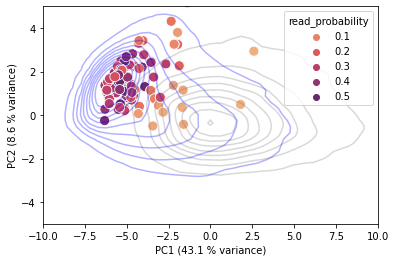

In [201]:
i = 2

site = sorted_sites[i]
# sort_idx = np.arange()
 
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)

points = to_plot_df[to_plot_df["site"] == site]
wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
combined_rep = np.concatenate([wt_rep, ko_rep])

wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
data_type = np.concatenate([wt_labels, ko_labels])

to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                        'read_probability': read_probs,
                        'site_probability': site_probs,
                        'data_type': data_type})

sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
                   hue="read_probability", 
                palette='flare',
                data=to_plot, s=100,vmin=0, vmax=1,
                alpha=1,
                ax=f.axes)
f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))

f.figure.savefig("quantification_plot_3.svg")
f.figure

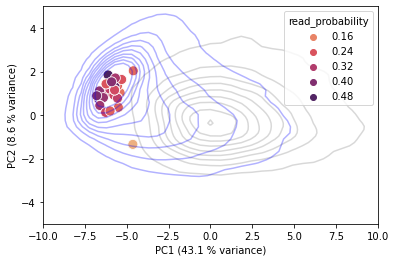

In [199]:
i = 3

site = sorted_sites[i]
# sort_idx = np.arange()
 
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)

points = sampled_plot_df[sampled_plot_df["site"] == site]
wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
combined_rep = np.concatenate([wt_rep, ko_rep])

wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
data_type = np.concatenate([wt_labels, ko_labels])

to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                        'read_probability': read_probs,
                        'site_probability': site_probs,
                        'data_type': data_type})

sns.scatterplot(x='PC1', y='PC2'.format(ratio[1]), 
                   hue="read_probability", 
                palette='flare',
                data=to_plot, s=100,vmin=0, vmax=1,
                alpha=1,
                ax=f.axes)
f.axes.set_xlabel('PC1 ({} % variance)'.format(round(ratio[0] * 100, 1)))
f.axes.set_ylabel('PC2 ({} % variance)'.format(round(ratio[1] * 100, 1)))

f.figure.savefig("quantification_plot_4.svg")
f.figure

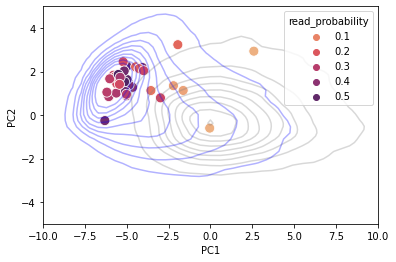

In [99]:
i = 1

sorted_sites = sampled_plot_df.groupby(["site"])["site_probability"].mean().sort_values(ascending=False).index

site = sorted_sites[i]
# sort_idx = np.arange()
 
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)

points = sampled_plot_df[sampled_plot_df["site"] == site]
wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values
combined_rep = np.concatenate([wt_rep, ko_rep])

wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values
ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values
ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values

read_probs = np.concatenate([wt_read_prob, ko_read_prob]).flatten()
site_probs = np.concatenate([wt_site_prob, ko_site_prob]).flatten()
data_type = np.concatenate([wt_labels, ko_labels])

to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                        'read_probability': read_probs,
                        'site_probability': site_probs,
                        'data_type': data_type})

sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                palette='flare',
                data=to_plot, s=100,
                alpha=1,
                ax=f.axes)
f.figure

In [20]:
ko_25_dl, ko_50_dl, ko_75_dl = hek293_dls['GohGIS_Hek293T-METTLE3-KO-25_directRNA_Rep1-Run1'], \
    hek293_dls['GohGIS_Hek293T-METTLE3-KO-50_directRNA_Rep1-Run1'], hek293_dls['GohGIS_Hek293T-METTLE3-KO-75_directRNA_Rep1-Run1']

all_sites = sampled_plot_df["site"].values
ko_reps = {}
reps_site = None
for dl, col in tqdm(zip([ko_25_dl, ko_50_dl, ko_75_dl], ['ko_25', 'ko_50', 'ko_75'])):
    sites = dl.dataset.data_info.apply(lambda x: "{}_{}".format(x["transcript_id"], 
                                                                x["transcript_position"]), axis=1).values
    index_col = "{}_index".format(col)
    ko_reps[col] = get_read_site_probability(model, dl, device)
    

0it [00:00, ?it/s]

In [21]:
shared_sites_all = shared_sites.copy(deep=True)

for dl, col in tqdm(zip([ko_25_dl, ko_50_dl, ko_75_dl], ['ko_25', 'ko_50', 'ko_75'])):
    data_info = dl.dataset.data_info
    col_index = "{}_index".format(col)
    data_info[col_index] = np.arange(len(data_info))
    shared_sites_all = shared_sites_all.merge(data_info.set_index(["transcript_id", "transcript_position"])[col_index],
                                              on=["transcript_id", "transcript_position"])

0it [00:00, ?it/s]

In [22]:
shared_sites_all.shape

(63531, 18)

In [74]:
import pickle

In [221]:
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)
    f.figure.savefig("kde_contours_4_kmers.svg")

In [275]:
i = 1

site = "{}_{}".format(shared_sites_all["transcript_id"].values[i], shared_sites_all["transcript_position"].values[i])

ko_25_idx = int(shared_sites_all["ko_25_index"].values[i])
ko_50_idx = int(shared_sites_all["ko_50_index"].values[i])
ko_75_idx = int(shared_sites_all["ko_75_index"].values[i])

points = sampled_plot_df[sampled_plot_df["site"] == site]
wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values

wt_read_prob = points[points["data_type"] == 'WT'][["read_probability"]].values.flatten()
ko_read_prob = points[points["data_type"] == 'KO'][["read_probability"]].values.flatten()

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT'][["site_probability"]].values.flatten()
ko_site_prob = points[points["data_type"] == 'KO'][["site_probability"]].values.flatten()


to_plot_wt = pd.DataFrame({'PC1': wt_rep[:, 0], 'PC2': wt_rep[:, 1],
                        'read_probability': wt_read_prob,
                        'site_probability': wt_site_prob})

to_plot_ko = pd.DataFrame({'PC1': ko_rep[:, 0], 'PC2': ko_rep[:, 1],
                        'read_probability': ko_read_prob,
                        'site_probability': ko_site_prob})

mixture_reps = {}

for col, idx in zip(['ko_25', 'ko_50', 'ko_75'], [ko_25_idx, ko_50_idx, ko_75_idx]):
    samples_idx = np.random.choice(100, 20, replace=False)
    pred_read, pred_site, rep = ko_reps[col]
    pred_read = pred_read[idx].flatten()[samples_idx].flatten()
    rep = pca.transform(scaler.transform(rep[idx]))[samples_idx]
    mixture_reps[col] = pd.DataFrame({'PC1': rep[:, 0], 'PC2': rep[:, 1],
                                      'read_probability': pred_read})
    
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    f = pickle.load(fid)
    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=to_plot_wt, s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=f.axes)

with open('kde_plot_4_kmers.pkl','rb') as fid:
    g = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=to_plot_ko, s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=g.axes)

with open('kde_plot_4_kmers.pkl','rb') as fid:
    h = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=mixture_reps['ko_25'], s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=h.axes)
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    i = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=mixture_reps['ko_50'], s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=i.axes)
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    j = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=mixture_reps['ko_75'], s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=j.axes)
# f.figure
# g.figure

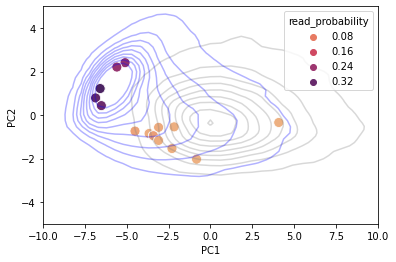

In [276]:
f.figure

In [75]:
shared_sites_all["site"] = shared_sites_all.apply(lambda x: "{}_{}".format(x["transcript_id"], 
                                                                           x["transcript_position"]), 
                                                  axis=1)
ko_25_idx = shared_sites_all["ko_25_index"].apply(lambda x: int(x)).values
ko_50_idx = shared_sites_all["ko_50_index"].apply(lambda x: int(x)).values
ko_75_idx = shared_sites_all["ko_75_index"].apply(lambda x: int(x)).values

points = sampled_plot_df[sampled_plot_df["site"].isin(shared_sites_all["site"])].reset_index(drop=True)

wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values

wt_read_prob = points[points["data_type"] == 'WT']["read_probability"].values.flatten()
ko_read_prob = points[points["data_type"] == 'KO']["read_probability"].values.flatten()

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT']["site_probability"].values.flatten()
ko_site_prob = points[points["data_type"] == 'KO']["site_probability"].values.flatten()


to_plot_wt = pd.DataFrame({'PC1': wt_rep[:, 0], 'PC2': wt_rep[:, 1],
                        'read_probability': wt_read_prob,
                        'site_probability': wt_site_prob})

to_plot_ko = pd.DataFrame({'PC1': ko_rep[:, 0], 'PC2': ko_rep[:, 1],
                           'read_probability': ko_read_prob,
                           'site_probability': ko_site_prob})

mixture_reps = {}

for col, idx in zip(['ko_25', 'ko_50', 'ko_75'], [ko_25_idx, ko_50_idx, ko_75_idx]):
    samples_idx = np.concatenate([(100 *i) + np.random.choice(100, 20, replace=False) for i in range(len(idx))])
    pred_read, pred_site, rep = ko_reps[col]
    pred_read = pred_read[idx].flatten()[samples_idx].flatten()
    rep = pca.transform(scaler.transform(rep[idx].reshape(-1, 32)))[samples_idx]
    mixture_reps[col] = pd.DataFrame({'PC1': rep[:, 0], 'PC2': rep[:, 1],
                                      'read_probability': pred_read})
    

with open('kde_plot_4_kmers.pkl','rb') as fid:
    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=to_plot_wt, s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=f.axes)

with open('kde_plot_4_kmers.pkl','rb') as fid:
    g = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=to_plot_ko, s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=g.axes)

with open('kde_plot_4_kmers.pkl','rb') as fid:
    h = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=mixture_reps['ko_25'], s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=h.axes)
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    i = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=mixture_reps['ko_50'], s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=i.axes)
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    j = pickle.load(fid)

    sns.scatterplot(x='PC1', y='PC2', hue="read_probability", 
                    palette='flare',
                    data=mixture_reps['ko_75'], s=100,
                    alpha=1,vmin=0, vmax=1,
                    ax=j.axes)
# f.figure
# g.figure

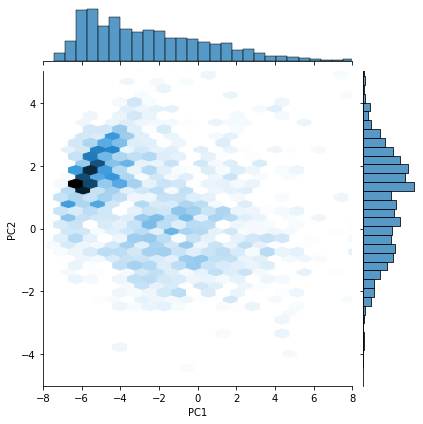

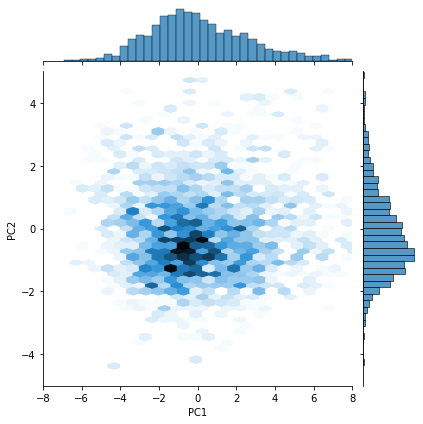

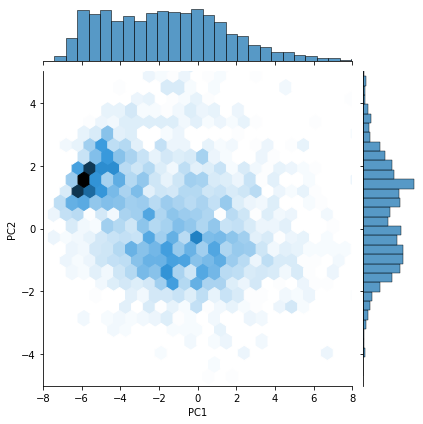

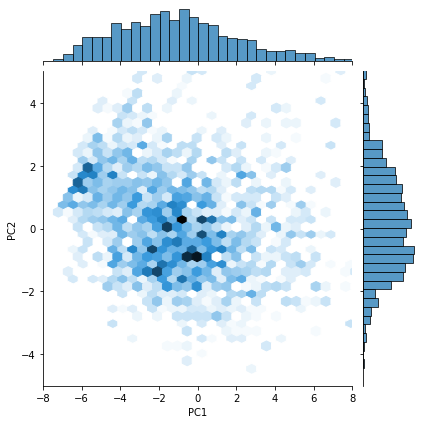

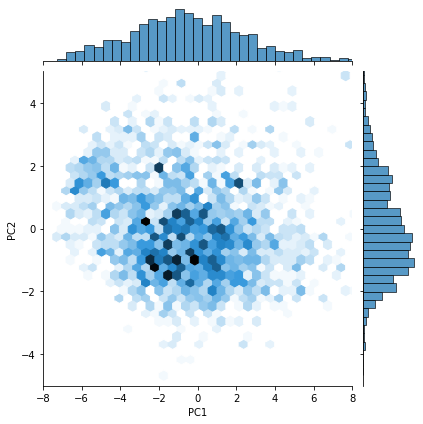

In [223]:
shared_sites_all["site"] = shared_sites_all.apply(lambda x: "{}_{}".format(x["transcript_id"], 
                                                                           x["transcript_position"]), 
                                                  axis=1)
ko_25_idx = shared_sites_all["ko_25_index"].apply(lambda x: int(x)).values
ko_50_idx = shared_sites_all["ko_50_index"].apply(lambda x: int(x)).values
ko_75_idx = shared_sites_all["ko_75_index"].apply(lambda x: int(x)).values

points = to_plot_df[to_plot_df["site"].isin(shared_sites_all["site"])].reset_index(drop=True)

wt_rep = points[points["data_type"] == 'WT'][["PC1", "PC2"]].values
ko_rep = points[points["data_type"] == 'KO'][["PC1", "PC2"]].values

wt_read_prob = points[points["data_type"] == 'WT']["read_probability"].values.flatten()
ko_read_prob = points[points["data_type"] == 'KO']["read_probability"].values.flatten()

wt_labels, ko_labels = np.repeat("WT", len(wt_read_prob)), np.repeat("KO", len(ko_read_prob))

wt_site_prob = points[points["data_type"] == 'WT']["site_probability"].values.flatten()
ko_site_prob = points[points["data_type"] == 'KO']["site_probability"].values.flatten()


to_plot_wt = pd.DataFrame({'PC1': wt_rep[:, 0], 'PC2': wt_rep[:, 1],
                        'read_probability': wt_read_prob,
                        'site_probability': wt_site_prob})

to_plot_ko = pd.DataFrame({'PC1': ko_rep[:, 0], 'PC2': ko_rep[:, 1],
                           'read_probability': ko_read_prob,
                           'site_probability': ko_site_prob})

mixture_reps = {}

for col, idx in zip(['ko_25', 'ko_50', 'ko_75'], [ko_25_idx, ko_50_idx, ko_75_idx]):
    pred_read, pred_site, rep = ko_reps[col]
    pred_read = pred_read[idx].flatten().flatten()
    rep = pca.transform(scaler.transform(rep[idx].reshape(-1, 32)))
    mixture_reps[col] = pd.DataFrame({'PC1': rep[:, 0], 'PC2': rep[:, 1],
                                      'read_probability': pred_read})
    

with open('kde_plot_4_kmers.pkl','rb') as fid:
    a = sns.jointplot(x='PC1', y='PC2',
                    palette='flare',
                    data=to_plot_wt,
                    kind='hex')
    a.ax_marg_x.set_xlim(-8, 8)
    a.ax_marg_y.set_ylim(-5, 5)
    a.fig.savefig("wt_hexplot.svg")
with open('kde_plot_4_kmers.pkl','rb') as fid:
    b = sns.jointplot(x='PC1', y='PC2',  
                    palette='flare',
                    data=to_plot_ko,
                    kind='hex')
    b.ax_marg_x.set_xlim(-8, 8)
    b.ax_marg_y.set_ylim(-5, 5)
    b.fig.savefig("ko_25_hexplot.svg")
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    c = sns.jointplot(x='PC1', y='PC2', 
                    palette='flare',
                    data=mixture_reps['ko_25'],
                    kind='hex')
    c.ax_marg_x.set_xlim(-8, 8)
    c.ax_marg_y.set_ylim(-5, 5)
    c.fig.savefig("ko_50_hexplot.svg")
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    d = sns.jointplot(x='PC1', y='PC2',
                    palette='flare',
                    data=mixture_reps['ko_50'], kind='hex')
    d.ax_marg_x.set_xlim(-8, 8)
    d.ax_marg_y.set_ylim(-5, 5)
    d.fig.savefig("ko_75_hexplot.svg")
    
with open('kde_plot_4_kmers.pkl','rb') as fid:
    e = sns.jointplot(x='PC1', y='PC2',
                    palette='flare',
                    data=mixture_reps['ko_75'],kind='hex')
    e.ax_marg_x.set_xlim(-8, 8)
    e.ax_marg_y.set_ylim(-5, 5)
    e.fig.savefig("ko_100_hexplot.svg")
# f.figure
# g.figure

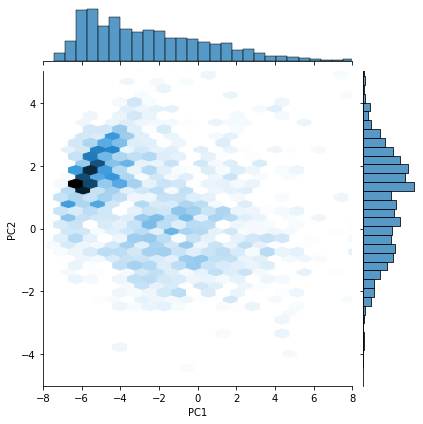

In [132]:
a.fig

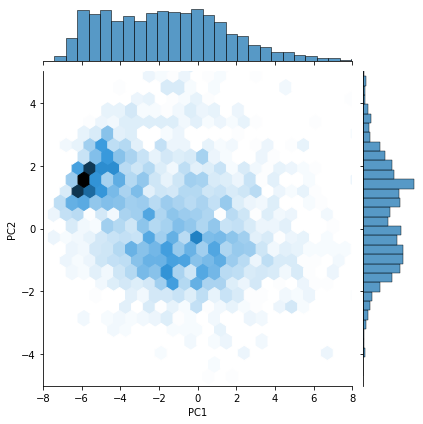

In [133]:
c.fig

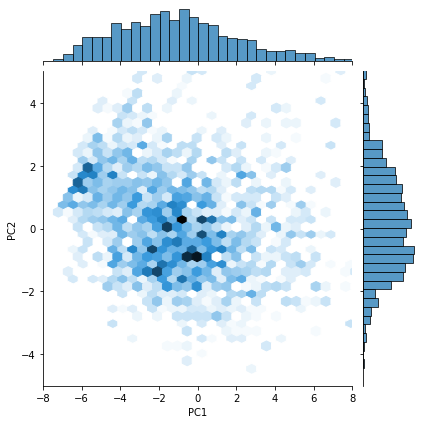

In [134]:
d.fig

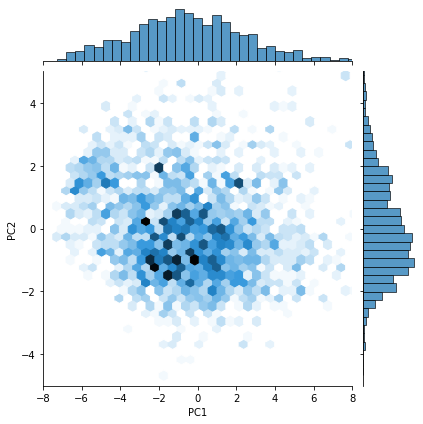

In [136]:
e.fig

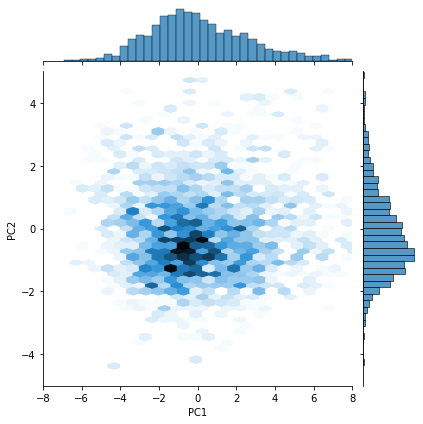

In [137]:
b.fig

In [17]:
import matplotlib as mpl
import matplotlib.colors as clr


In [18]:
def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)

chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

In [19]:
shared_df = None
ko_pcts = ["KO_0", "KO_25", "KO_50", "KO_75", "KO_100"]
features = ["gene_id", "genomic_position", "probability_modified"]
for input_dir, ko_pct in zip(hek293_dirs, ko_pcts):
    result_fpath = os.path.join(input_dir, "prod_pooling", "data.result.csv")
    probability_df = pd.read_csv(result_fpath)
    probability_df = add_chromosome_and_gene_info(probability_df)
    probability_df = add_genomic_position(probability_df)
    
    probability_df = probability_df[features].groupby(["gene_id", "genomic_position"]).mean().reset_index()
    probability_df = probability_df.rename({'probability_modified': 'probability_modified_{}'.format(ko_pct)}, 
                                            axis=1)
    if shared_df is None:
        shared_df = probability_df
    else:
        shared_df = shared_df.merge(probability_df, on=["gene_id", "genomic_position"])


  0%|          | 0/4662 [00:00<?, ?it/s]

  0%|          | 0/6141 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/4672 [00:00<?, ?it/s]

  0%|          | 0/6423 [00:00<?, ?it/s]

In [20]:
cols = ["id", "position", "kmer", "mod_rate_WT", 
        "mod_rate_KO",
        "pval_KO_vs_WT"]
ko_table = pd.read_csv("/data03/christopher/diffmod.table", usecols=cols)
ko_table = ko_table.rename(columns={'pval_KO_vs_WT': 'pvalue',
                                    'id': 'gene_id',
                                    'position': 'genomic_position'})

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

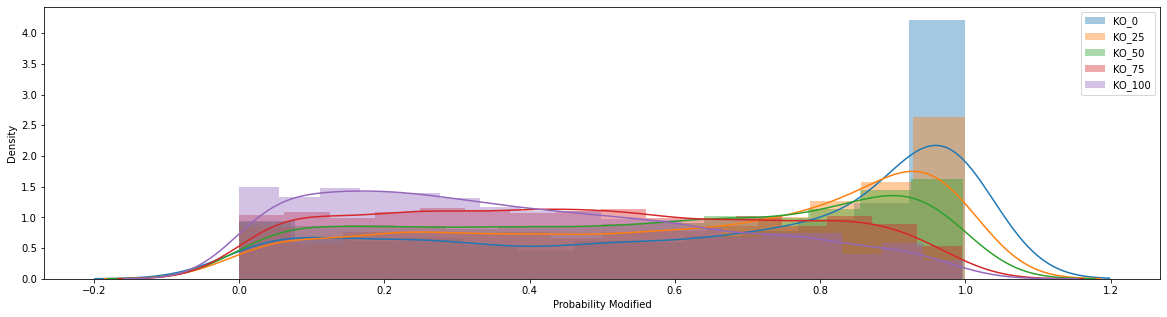

In [21]:
from statsmodels.stats.multitest import multipletests

alpha = 0.05

result_df_agg = shared_df.merge(ko_table, on=["gene_id", "genomic_position"], how='left')
result_df_agg = result_df_agg.fillna(1)
result_df_agg["pvalue"] = multipletests(result_df_agg.pvalue, alpha=alpha, method='fdr_bh')[1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=True)
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]
mask = result_df_agg["pvalue"] < alpha
for col, ko_pct in zip(proba_cols, ko_pcts):
    sns.distplot(result_df_agg[mask][col], ax=ax, label=ko_pct)

ax.set_xlabel("Probability Modified")
plt.legend()
fig.savefig("ko_wt_barplots.svg")

There are 9 positions
There are 9 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

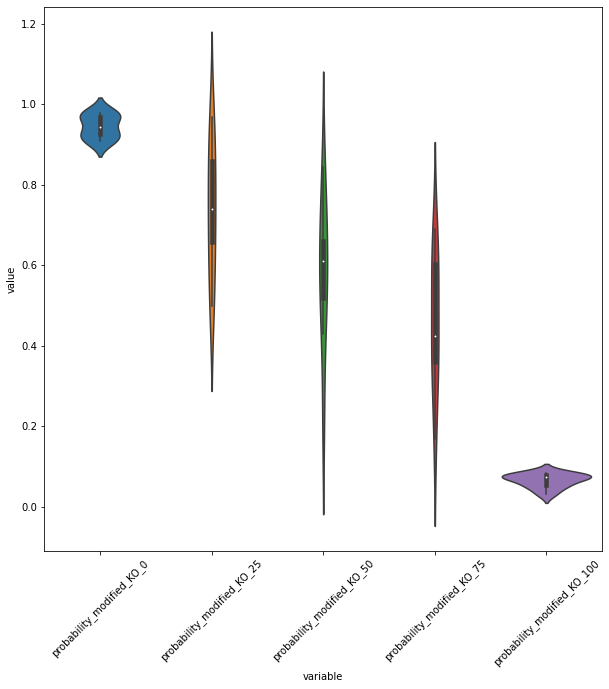

In [23]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]

# mask = result_df_agg["pvalue"] < alpha
confidence_mask = (result_df_agg["probability_modified_KO_0"] >= 0.9) & \
    (result_df_agg["probability_modified_KO_100"] < 0.1)

mask = confidence_mask
print("There are {} positions".format(mask.sum()))
result_df_agg_filtered = result_df_agg[mask]
print("There are {} sites in the plot".format(len(result_df_agg_filtered)))

result_df_agg_filtered_melt = pd.melt(result_df_agg_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=result_df_agg_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)
# fig.savefig("violin_plot_mixture.svg")

There are 104 sites in the plot


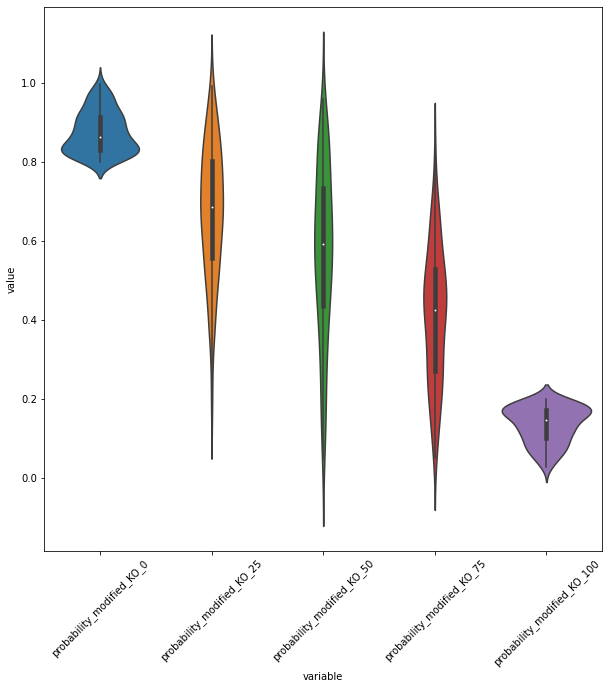

In [24]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]

# mask = result_df_agg["pvalue"] < alpha
confidence_mask = (result_df_agg["probability_modified_KO_0"] >= 0.8) & \
    (result_df_agg["probability_modified_KO_100"] < 0.2)

mask = confidence_mask
result_df_agg_filtered = result_df_agg[mask]
print("There are {} sites in the plot".format(len(result_df_agg_filtered)))

result_df_agg_filtered_melt = pd.melt(result_df_agg_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=result_df_agg_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)
fig.savefig("violin_plot_mixture.svg")

There are 65 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

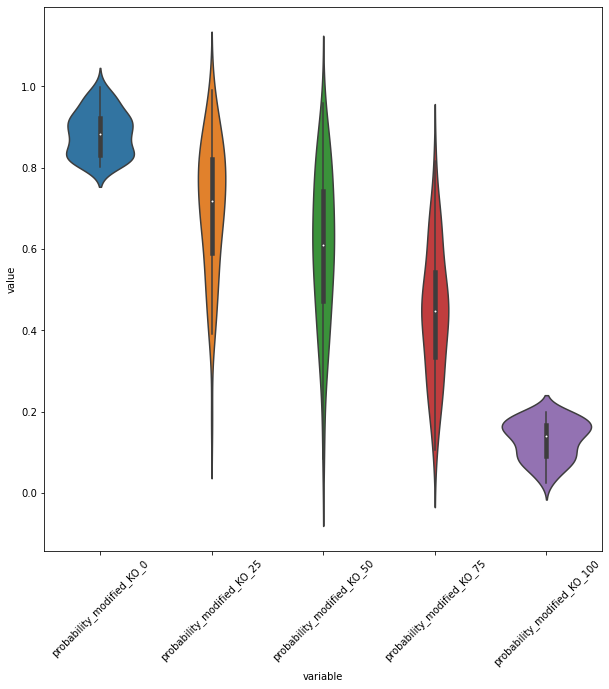

In [269]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]

mask = result_df_agg["pvalue"] < alpha
# confidence_mask = (result_df_agg["probability_modified_KO_0"] >= 0.8) & \
#     (result_df_agg["probability_modified_KO_100"] < 0.2)

mask = mask & confidence_mask
result_df_agg_filtered = result_df_agg[mask]
print("There are {} sites in the plot".format(len(result_df_agg_filtered)))

result_df_agg_filtered_melt = pd.melt(result_df_agg_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=result_df_agg_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)

There are 104 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

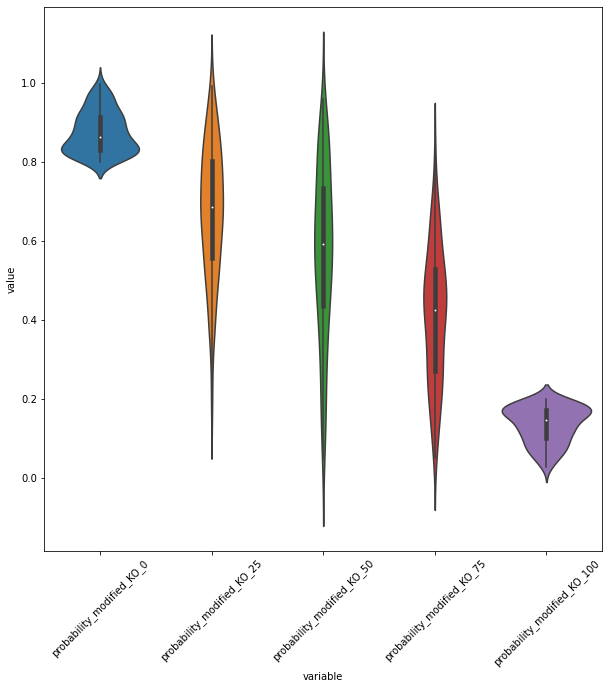

In [263]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]

confidence_mask = (shared_df["probability_modified_KO_0"] >= 0.8) & \
    (shared_df["probability_modified_KO_100"] < 0.2)

shared_df_filtered = shared_df[confidence_mask]
print("There are {} sites in the plot".format(len(shared_df_filtered)))

shared_df_filtered_melt = pd.melt(shared_df_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=shared_df_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)